# T-sne on  Amazon Fine Food Reviews Analysis

In [18]:
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')
import datetime as dt
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os




### Connecting to the pre-processed SQLITE database file 

In [3]:
#Connecting to the SQL table
con = sqlite3.connect('final.sqlite')

#Reading data from the database

Data = pd.read_sql_query("""
SELECT *
FROM Reviews """,con)
Data.shape

# Drop index column
Data.drop(columns=['index'],inplace=True)


### Preparing the data for the further use 

In [4]:
# Convert timestamp to datetime.

Data['Time'] = Data[['Time']].applymap(lambda x: dt.datetime.fromtimestamp(x))

#Setting Time column as index of the dataframe 
Data.set_index("Time",inplace=True)

#Sampling the above data

Sampled_data=Data.sample(n=8000,replace='False')
Sorted=Sampled_data.sort_index()


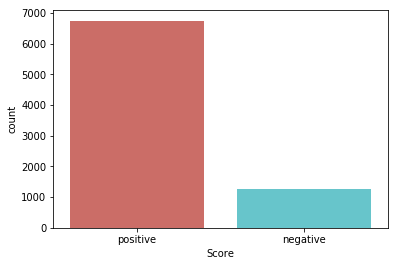

In [5]:
polarity=Sorted["Score"]
sns.countplot(x="Score",data=Sorted,palette="hls")
plt.show()



## Implementing the Bag-of-word technique

In [6]:
#Bag of words implementation

count_vect = CountVectorizer() #in scikit-learn
Bow = count_vect.fit_transform(Sorted['CleanedText'].values)

#Printing shape of the data
Bow.get_shape()

(8000, 12039)

OBSERVATION:
  * I have implemented the (BOW) technique over a small subset of data due to compute constraints 
  * By implementing the BOW technique over the preprocessed data each word in the review has been saved into a dictionary
  * Each review is converted into a vector represntation which is sparse.
  * There are 11898 unique words present in the matrix each word representing a dimension.
  * In BOW representation a sparse matrix of size (8000, 11898) is constructed. 

In [6]:
#Converting the sparse matrix into dense array

Dense_2=Bow.toarray(order="C",out= None)
print (polarity.shape)

(8000,)


## Utility function for plotting the TSNE  plot 

In [14]:


#Implementing TSNE for reducing the dimensionality of the given data

from sklearn.manifold import TSNE

def tsne(Dense,polarity,p,n,title):
    data = Dense[0::]
    Class = polarity[0:]
 
    #Using the default parameters of the T-sne module with perplexity 30 & iteration as 1000    
    model = TSNE(n_components=2, random_state=0,perplexity=p,  n_iter=n)

    Tsne_data = model.fit_transform(data)


    # creating a new data frame which help us in ploting the result data
    Tsne_data = np.vstack((Tsne_data.T, Class)).T
    Tsne_df = pd.DataFrame(data=Tsne_data, columns=("Dim_1", "Dim_2", "Class"))

    # Ploting the result of tsne
    sns.FacetGrid(Tsne_df, hue="Class",height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    plt.title(title)
    plt.show()



## Implementing the TSNE plot for the BOW vectorization

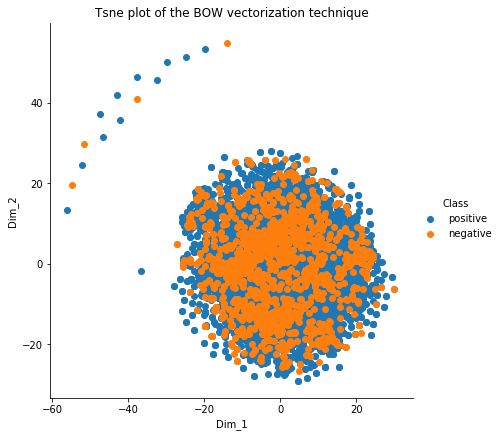

Wall time: 24min 27s


In [12]:
%%time

name="Tsne plot of the BOW vectorization technique"
tsne(Dense_2,polarity,30,1000,name)

### Observation:
<ul>
    <li>In the BOW model the text is represented as a bag(Multiset) of its words.Making each word as a feature.</li> 
    <li>So to visualize the BOW data in a 2-d space. I used T-SNE as a dimensionality reduction rechnique.</li>
    <li>In the above visualition  features are selected automatically by T-sne in which maximum variance(info) is retained.</li>
    <li>In the above visualization BLUE= +ve reviews  & Orange= -ve reviews.</li>
    <li>The points which are visually together are grouped together. Default parameters of the T-sne are used (P=30,I=1000)</li>
    <li>Let's try with different values of perplexity and iterations over the same vectorizer.</li>

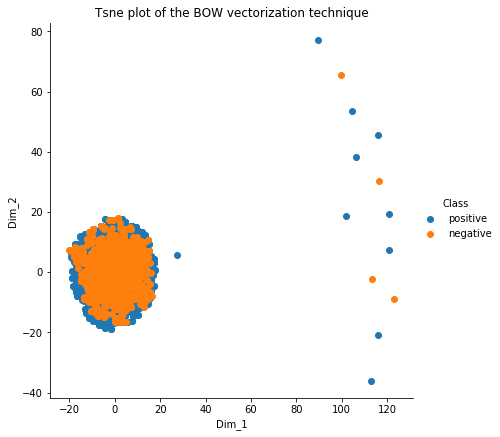

Wall time: 47min 7s


In [14]:
%%time
#TSNE PLOT WITH PERPLEXITY=50 AND ITERATION=5000
tsne(Dense_2,polarity,50,5000,name)

Observation:

    *In the previous plot the structure was somewhat stable and I rerun the T-sne plot with(P=50,I=5000).
    *In this above plot Blue=+ve , Orange=-ve (reviews).
    *Since T-sne is computationally expensive so I took a sample of points.
    *The structure is not that clear as there is a lot of overlapps and the points are clearly seen on the previous settings.

## Implementing the TF-IDF Vectorization technique

In [8]:
# Initializing the TF-idf vector over sample data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=5)
final_tf_idf = tf_idf_vect.fit_transform(Sorted['CleanedText'].values)
final_tf_idf.get_shape()


(8000, 10620)

#### Converting the sparse data into dense representation 

In [9]:
#Converting the sparse matrix into dense array

Dense_3=final_tf_idf.toarray(order="C",out= None)
print (polarity.shape)

(8000,)


#### TSNE-Implementation of the TF-IDF  vectorization technique

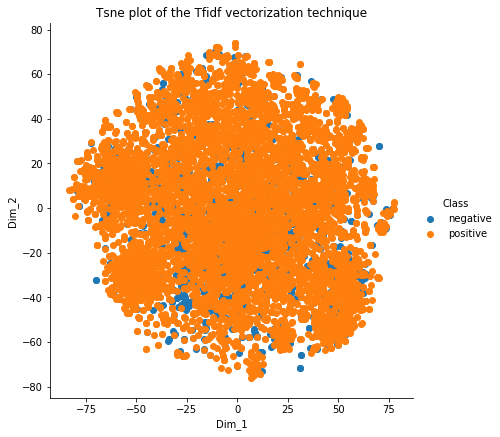

Wall time: 21min 44s


In [10]:
%%time

name="Tsne plot of the Tfidf vectorization technique"
tsne(Dense_3,polarity,30,1000,name)

#### TSNE plot with Perplexity =50 and Iteration =5000

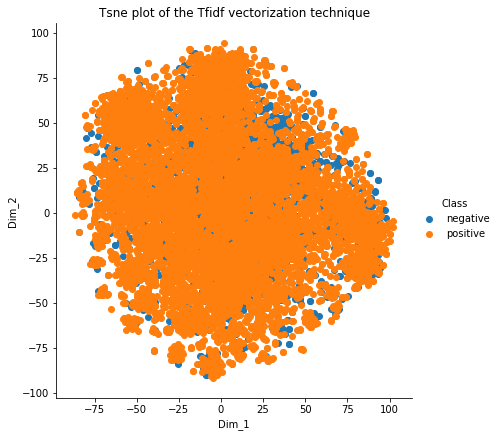

Wall time: 36min 14s


In [11]:
%%time

name="Tsne plot of the Tfidf vectorization technique"
tsne(Dense_3,polarity,50,5000,name)

### Observation:
  <ul>   
    <li>Since Tf-idf retains the sequence information of the words by using the n-grams technique.</li>
    <li>Tf-idf is a numerical statistic that reflects how important a word is to a document in a collection ofcorpus.</li>
    <li>Tfidf is more powerfull than BOW.Here both frequent and less frequent words are given importance.</li>
    <li>83% of text-based recommender systems in digital libraries use tf-idf.</li>
    <li>Tfidf increases the search power and good for information retrieval system.</li>
    <li>In both the T-sne plots the second plot got better results & have a stable structure.(p=50,I=5000).</li>
    <li>The TF-idf values ranges from(0-1) so feature selections can be done on Tfidf values.</li>
    <li>In this technique the semantic meaning of the words are not retained.</li> 

## Implementing the Word-2-vectorization technique

In [8]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in Sorted['CleanedText'].values:
    list_of_sent.append(sent.split())

In [9]:
print(Sorted['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

beetlejuic excel funni movi keaton hilari wacki beetlejuic great special effect help film think one best movi ever made sure youll agre good time watch beetlejuic
*****************************************************************
['beetlejuic', 'excel', 'funni', 'movi', 'keaton', 'hilari', 'wacki', 'beetlejuic', 'great', 'special', 'effect', 'help', 'film', 'think', 'one', 'best', 'movi', 'ever', 'made', 'sure', 'youll', 'agre', 'good', 'time', 'watch', 'beetlejuic']


### Creating the word Vocabulary of the CleanedText  

In [10]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [11]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4085
sample words  ['excel', 'funni', 'movi', 'great', 'special', 'effect', 'help', 'film', 'think', 'one', 'best', 'ever', 'made', 'sure', 'youll', 'agre', 'good', 'time', 'watch', 'never', 'dissapoint', 'compani', 'come', 'brother', 'pick', 'new', 'absolut', 'awesom', 'wife', 'like', 'white', 'red', 'realli', 'handi', 'also', 'love', 'click', 'sound', 'make', 'vacuum', 'correct', 'level', 'neat', 'design', 'look', 'gift', 'invent', 'save', 'wine', 'use']


   ### Finding the Semantic meanings of the queryed words

In [20]:
w2v_model.wv.most_similar('tasti')

[('textur', 0.9715499877929688),
 ('balanc', 0.9710178971290588),
 ('crunchi', 0.9693207144737244),
 ('chewi', 0.9646049737930298),
 ('satisfi', 0.9643993377685547),
 ('salti', 0.9629777669906616),
 ('real', 0.9556394815444946),
 ('crunch', 0.9536905884742737),
 ('over', 0.9487769603729248),
 ('tart', 0.9439001679420471)]

In [21]:
w2v_model.wv.most_similar('like')

[('doesnt', 0.9113660454750061),
 ('realli', 0.8914791941642761),
 ('anyth', 0.8760069012641907),
 ('butterscotch', 0.8712275624275208),
 ('smell', 0.8696292042732239),
 ('actual', 0.8635614514350891),
 ('textur', 0.8595040440559387),
 ('someth', 0.859350323677063),
 ('person', 0.8566683530807495),
 ('spici', 0.8565115332603455)]

## Observations:
 <ul>   
      <li>Gensim is the library for w2v. The word2vec is a standard deeplearning technique used in semantic analysis.</li>  
      <li> Skipgram & cbow are the 2 most widely used w2v implementations.</li>
      <li>Word2vec tries to retain the semantic meaning of the words.which makes it far more powerfull then other techniques.</li> <li>First a text corpus/vocabulary is build,w2v tries to take text as input from the corpus and produces a vector space.</li> <li>Here each unique word in the corpus being assigned as a corresponding vector in the vector space.</li>
       <li>Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in           close proximity to one another in the space.</li>

### Implementing the Average-word2vectorization technique

In [16]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:04<00:00, 1632.27it/s]


8000
50


###  Implementing the TSNE plot of the average word2vec technique

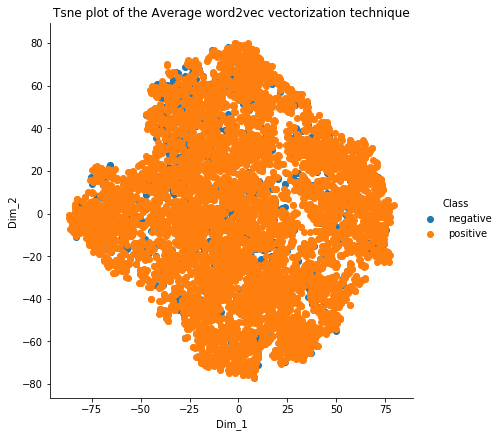

Wall time: 3min


In [27]:
%%time
name="Tsne plot of the Average word2vec vectorization technique"
tsne(sent_vectors,polarity,30,1000,name)

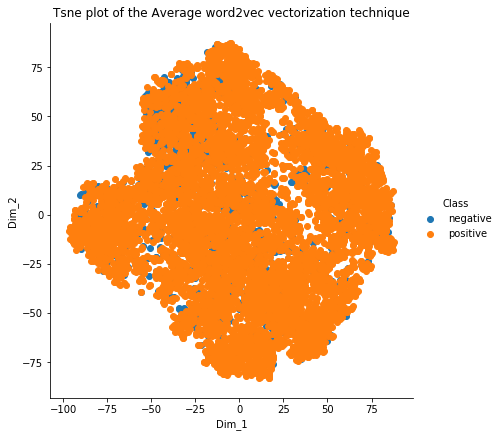

Wall time: 19min 12s


In [28]:
%%time
name="Tsne plot of the Average word2vec vectorization technique"
tsne(sent_vectors,polarity,50,5000,name)

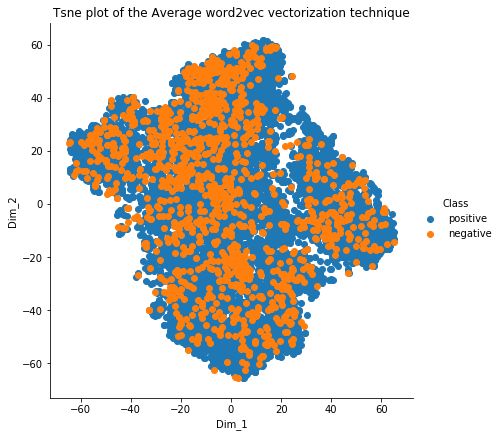

Wall time: 25min 34s


In [17]:
%%time
name="Tsne plot of the Average word2vec vectorization technique"
tsne(sent_vectors,polarity,80,5000,name)

<h2>Observations</h2>
<ul>
    <li>After constructing the word embedding by using the word-2-vec technique which was quite successfull I have to visualize the input so I used T-sne.</li>
    <li>Since T-sne is computationaly heavy I created a word embedding vocabulary by using just 8000 datapoints and 8000 labels.</li>
    <li>Avg w2v technique is used to create the numerical representaion of the vocabulary which will be usefull for T-sne visualization</li>
    <li>By using the default values of the T-sne technique the result was somewhat interesting but not interpretable but I ran T-sne for multiple perplexity values</li>
    <li>At perplexity value of 50 and iteration of 50000 the the clusters were not that different so I increased the perplexity values from 50 to 80 and the results was satisfactory and interpretable.</li>
</ul>

### Implementing TFIDF-Weighted-word2vec technique

In [12]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(Sorted['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [13]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:06<00:00, 1312.19it/s]


### TSNE PLOT OF THE ABOVE VECTORIZER

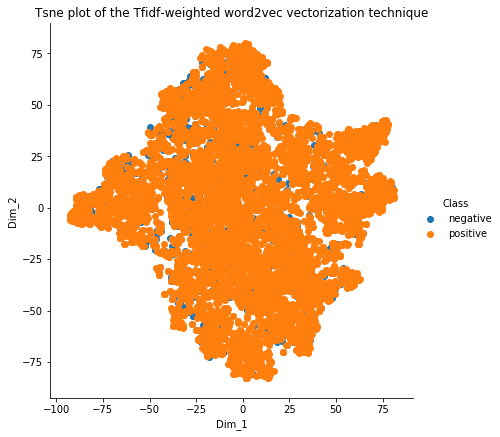

Wall time: 3min 3s


In [29]:
%%time
name="Tsne plot of the Tfidf-weighted word2vec vectorization technique"
tsne(tfidf_sent_vectors,polarity,30,1000,name)

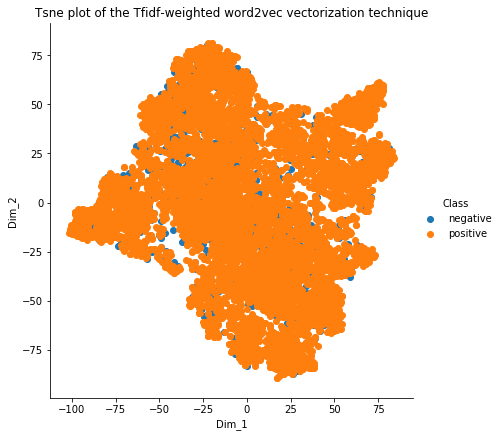

Wall time: 19min 30s


In [30]:
%%time
name="Tsne plot of the Tfidf-weighted word2vec vectorization technique"
tsne(tfidf_sent_vectors,polarity,50,5000,name)

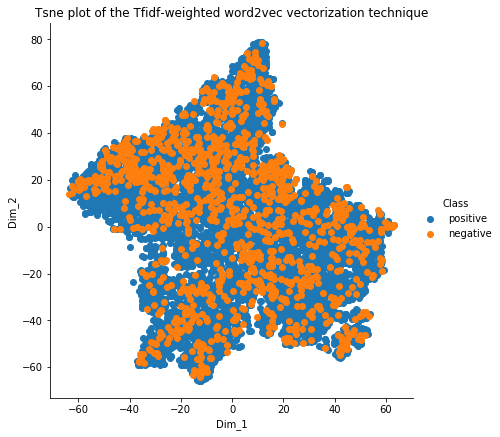

Wall time: 25min 26s


In [15]:
%%time
name="Tsne plot of the Tfidf-weighted word2vec vectorization technique"
tsne(tfidf_sent_vectors,polarity,80,5000,name)

<h2>Observations</h2>
<ul>
    <li>The Tf-idf W2V is a weighted average tecchnique in which the features having more importance are used which can improve the model's performance</li>
    <li>In the T-sne visualization with perplexity=50 and iteration=5000 the visualization is not so clear due to overlapping of the two class labels are severe</li>
    <li>So I increased the perplexity to 80 keeping the iteration constant and the results were satisfactory.</li>
    <li>In the third T-sne plot the clusters are somewhat stable hence results is nice and clear visualization is seen</li>
</ul>

<center><h2>Conclusion</h2></center> 

<ul>
    <li>After vectorizing the text data the dimensionality increases very rapidly and to visualize this type of data TSNE is one of the best technique which can be used for dimensionality reduction and data visualization.</li>
    <li>The TSNE technique is very computationaly expensive and take a long time to execute so large datapoints cannot be taken at a time in a single box enviornment which I think is a limitations of this technique.</li>
    <li>The visualization is best as compared to other techniques as it try to retain the original structure of the data.</li>
    <li>For better results I had tried various values of perplexity and iteration and choosed that value which gave proper visualization.</li>